In [3]:
import yaml
import torch
import numpy as np
from torch_geometric.loader import DataLoader
import pandas as pd
import random
from model import ILBERT,ILBERT_T,ILBERT_T_P
from dataset import SMILES_dataset
from ILtokenizer import SMILES_Atomwise_Tokenizer
from tqdm import tqdm


def predict_csv(data_file,task):
    config_path = "config.yaml"
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    model_paths = [
        f'model_weight/{task}/fold_1_best_model.pth',
        f'model_weight/{task}/fold_2_best_model.pth',
        f'model_weight/{task}/fold_3_best_model.pth',
        f'model_weight/{task}/fold_4_best_model.pth',
        f'model_weight/{task}/fold_5_best_model.pth']
    
    if task =='Melting point':
        target='IL'
        means, stds = 363.0857, 75.0207         # tensor(363.0857) tensor(75.0207) torch.Size([26730, 1, 1])

    elif task =='Glass transition temperature':
        target='IL'
        means, stds = 215.6339, 29.5529          # tensor(215.6339) tensor(29.5529) torch.Size([7930, 1, 1])

    elif task =='Thermal decomposition temperature':
        target='IL'
        means, stds = 522.9653, 76.1426         # tensor(522.9653) tensor(76.1426) torch.Size([27790, 1, 1])

    elif task =='IPC-81':
        target='IL'
        means, stds = 3.1156, 1.0641            # tensor(3.1156) tensor(1.0641) torch.Size([3550, 1, 1])

    elif task =='Electrical conductivity':
        target='lnEC'
        means, stds = -1.0393, 1.5858            # tensor(-1.0393) tensor(1.5858) torch.Size([2168, 1, 1])

    elif task =='Thermal conductivity':
        target='TC/W m-1 K-1'
        means, stds = 0.1507, 0.0254            # tensor(0.1507) tensor(0.0254) torch.Size([606, 1, 1])

    elif task =='Density':
        target='d_kg m-3'
        means, stds = 1218.4255, 165.7802        # tensor(1218.4255) tensor(165.7802) torch.Size([39830, 1, 1])

    elif task =='Surface tension':
        target='s_mNm'
        means, stds = 38.2560, 9.0138            # tensor(38.2560) tensor(9.0138) torch.Size([5990, 1, 1])

    elif task =='Refractive index':
        target='R'
        means, stds = 1.4676, 0.0407            # tensor(1.4676) tensor(0.0407) torch.Size([3596, 1, 1])

    elif task =='Viscosity':
        target='ln(n_mPas)'
        means, stds = 4.1952, 1.6220            # tensor(4.1952) tensor(1.6220) torch.Size([15368, 1, 1])

    elif task =='CO2':
        target='ln(x_CO2)'
        means, stds = -1.5511, 1.2642            # tensor(0.3349) tensor(0.2362) torch.Size([10116, 1, 1])/ tensor(-1.5511) tensor(1.2642) torch.Size([10116, 1, 1])


    elif task =='Heat capacity':
        target='lnhc'
        means, stds = 6.2754, 0.3585            # tensor(6.2754) tensor(0.3585) torch.Size([11539, 1, 1])

    outputs = []

    test_dataset = SMILES_dataset(df=pd.read_csv(data_file), tokenizer=SMILES_Atomwise_Tokenizer('D:/QYX/SmilesPE-master/merged_vocab.txt'), target=target)

    for model_path in tqdm(model_paths, desc="Processing Models"):
    

        config = yaml.load(open(config_path, "r", encoding="utf-8"), Loader=yaml.FullLoader)

        if task in ['Melting point', 'Glass transition temperature', 'Thermal decomposition temperature', 'IPC-81']:
            best_model = ILBERT(**config["transformer"]).to(device)
        elif task in ['Electrical conductivity', 'Surface tension', 'Refractive index', 'Viscosity', 'Heat capacity']:
            best_model = ILBERT_T(**config["transformer"]).to(device)
        elif task in ['Thermal conductivity', 'Density', 'CO2']:
            best_model = ILBERT_T_P(**config["transformer"]).to(device)

        best_model.load_state_dict(torch.load(model_path))
        best_model.eval()
        
        test_loader = DataLoader(test_dataset, batch_size=512, shuffle=False)
        test_pred = []

        with torch.no_grad():
            for datas, _, _, _, _ in tqdm(test_loader, desc="Processing Batches", leave=False):
                data = [data.to(device) for data in datas]

                output = best_model(data)
                output = output * stds + means
                test_pred.extend(output.detach().cpu().numpy())

        outputs.append(test_pred)

    outputs = np.array(outputs)
    mean_outputs = np.mean(outputs, axis=0).flatten()
    std_outputs = np.std(outputs, axis=0).flatten()

    return mean_outputs, std_outputs




In [4]:
import numpy as np

def mean_absolute_relative_deviation(actual, pred):
    actual = np.array(actual)
    pred = np.array(pred)
    # 避免除以零
    nonzero_mask = actual != 0
    deviations = np.abs((pred[nonzero_mask] - actual[nonzero_mask]) / actual[nonzero_mask])
    return np.mean(deviations) if deviations.size > 0 else np.nan

import pandas as pd
from sklearn.metrics import mean_absolute_error, r2_score,root_mean_squared_error


data_flie = 'data/C/Norm_C.csv'


data = pd.read_csv(data_flie)
pred,stds= predict_csv(data_flie,'IPC-81')
actual_values = data['logEC50']


mae = mean_absolute_error(actual_values, pred)
rmse = root_mean_squared_error(actual_values, pred)
r2 = r2_score(actual_values, pred)
aard = mean_absolute_relative_deviation(actual_values, pred)

# Print metrics
print("MAE:", mae)
print("RMSE:", rmse)
print("R2:", r2)
print("AARD:", aard)




Processing Models: 100%|██████████| 5/5 [00:01<00:00,  3.96it/s]

MAE: 0.0849414944185371
RMSE: 0.12328204939121686
R2: 0.9865748177269891
AARD: 0.109203217517691


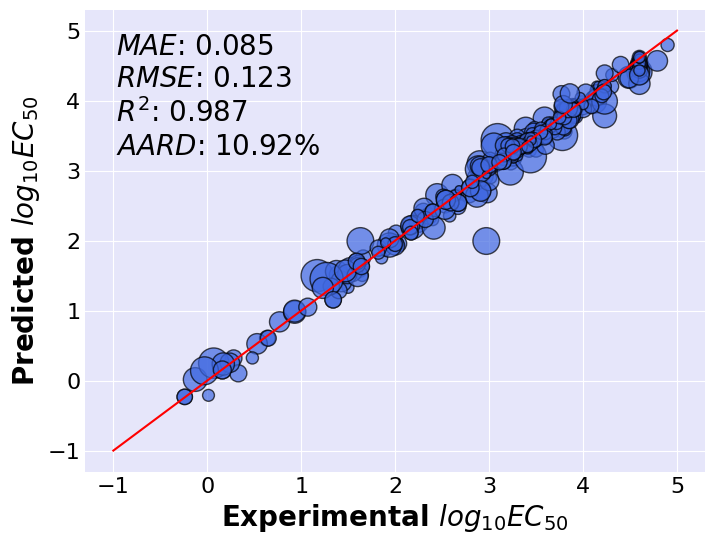

In [11]:

import numpy as np
import matplotlib.pyplot as plt

# Plotting
fig, ax = plt.subplots(figsize=(8,6))
ax.grid(color='white')
ax.plot([-1, 5], [-1, 5], linestyle='-', color='red')
# Scatter plot for acidic data
sc = ax.scatter(data['logEC50'], pred, c='royalblue', alpha=0.7, s=stds*1000, edgecolors='black')

ax.set_facecolor('lavender')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.tick_params(axis='both', which='both', length=0,labelsize=16)

# Add title and labels
ax.set_xlabel('Experimental $log_{10}EC_{50}$', fontsize=20, fontweight='bold')
ax.set_ylabel('Predicted $log_{10}EC_{50}$', fontsize=20, fontweight='bold')

ax.text(0.05, 0.95, f"$MAE$: {mae:.3f}\n$RMSE$: {rmse:.3f}\n$R^2$: {r2:.3f}\n$AARD$: {aard*100:.2f}%", fontsize=20, transform=ax.transAxes, verticalalignment='top')
ax.set_axisbelow(True)




plt.show()
